# Chapter 14. Computer Vision

## Chapter 14.1 Image Augmentation

In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

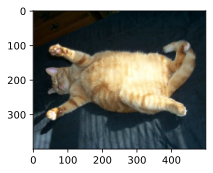

In [5]:
d2l.set_figsize()
img = d2l.Image.open('img/cat1.jpg')
d2l.plt.imshow(img);

In [6]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

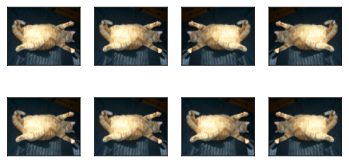

In [7]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

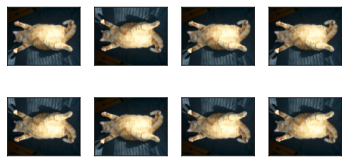

In [9]:
apply(img, torchvision.transforms.RandomVerticalFlip())

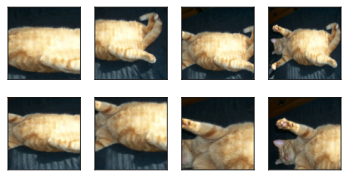

In [10]:
shape_aug = torchvision.transforms.RandomResizedCrop((200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

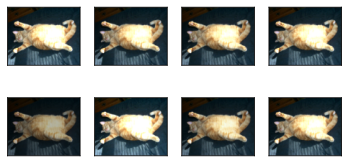

In [12]:
apply(img, torchvision.transforms.ColorJitter(brightness=0.5, contrast=0, saturation=0, hue=0))

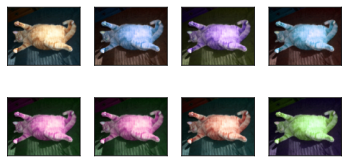

In [13]:
apply(img, torchvision.transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0.5))

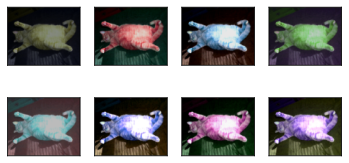

In [14]:
color_aug = torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

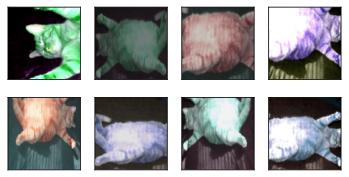

In [18]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
apply(img, augs)

100%|███████████████████████████████████████████████████████| 170498071/170498071 [00:34<00:00, 4880092.50it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data


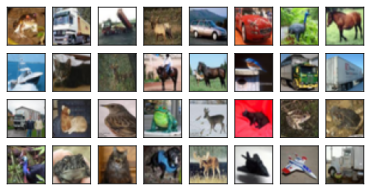

In [20]:
# Training with Image Augmentation

all_images = torchvision.datasets.CIFAR10(train=True, root="../data", download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);

In [23]:
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()
])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])


In [24]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root="../data", train=is_train, transforms=augs, download=True)
    
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                            shuffle=is_train, num_workers=d2l.get_dataloader_workers())
    
    return dataloader